In [1]:
!pip install --upgrade networkx

!pip install uvicorn
!pip install python-multipart
!pip install kaleido
!pip install fastapi

import json
import numpy as np
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt





[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install node2vec
from node2vec import Node2Vec

  Using cached networkx-2.8.8-py3-none-any.whl (2.0 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Paths
project_dir = "Learning from Networks/"
meta_path = 'clean_meta_Software.json'
ratings_path = 'ratings_Software.csv'



In [4]:
try:
    meta_df = pd.read_json("clean_data/"+meta_path, lines=True)
    meta_df = meta_df[["asin", "categories", "related", "price", "salesRank"]]
    meta_df['price'] = meta_df['price'].fillna(0)

    def fill_related(row):
      row = {'also_bought': [], 'also_viewed': [], 'bought_together': []} if pd.isna(row) else row
      row.setdefault('also_bought', [])
      row.setdefault('also_viewed', [])
      row.setdefault('bought_together', [])


      return row

    def fix_categories(row):
        return row[0]


    meta_df["related"] = meta_df["related"].apply(fill_related)
    meta_df["categories"] = meta_df["categories"].apply(fix_categories)


    print(meta_df)
except ValueError as e:
    print(f"Error reading JSON: {e}")


             asin                                         categories  \
0      0030429137  [Software, Business & Office, Visualization & ...   
1      0077338030   [Software, Education & Reference, Encyclopedias]   
2      0078798019                  [Software, Education & Reference]   
3      0080964184                            [Software, Photography]   
4      0131433172                                  [Movies & TV, TV]   
...           ...                                                ...   
18464  B00LEZEY4S                      [Software, Utilities, Backup]   
18465  B00LK2K692  [Software, Programming & Web Development, Prog...   
18466  B00LK2WEWY  [Software, Programming & Web Development, Prog...   
18467  B00LK1W8O4  [Software, Accounting & Finance, Personal Fina...   
18468  B00LNVBOG4   [Software, Education & Reference, Encyclopedias]   

                                                 related  price  \
0      {'also_bought': ['0030429145'], 'also_viewed':...   0.00   
1

In [5]:
# section associated to the rating fields: number_of_ratings, avg_rating

def aggregate(group):
    return pd.Series({
        "number_of_ratings": len(group['Rate'].tolist()),
        "avg_rating": np.average(group['Rate'])
    })

def create_nodeAttribute_dataframe(meta_df, rating_df):
    df = pd.merge(meta_df, rating_df, how='inner', on='asin')
    
    df = df.dropna(axis=1)

    # Get the union of all categories in the 'categories' column
    all_categories = set(category for categories_list in df['categories'] if categories_list is not None for category in categories_list)
    categories_one_hot = pd.DataFrame({category: [1 if category in categories_list else 0 for categories_list in df['categories']] for category in all_categories})
    df = pd.concat([df, categories_one_hot], axis=1)

    # Fill NaN values with 0
    df = df.fillna(0)


    df = df.drop('categories', axis=1)
    df = df.drop('Software', axis=1)

    df['number_of_ratings'] = df['number_of_ratings'].fillna(0)
    df['avg_rating'] = df['avg_rating'].fillna(0)
    return df

try:
    rating_df = pd.read_csv("clean_data/"+ratings_path, names=["User", "asin", "Rate", "Time"])
    rating_df = rating_df.groupby("asin").apply(aggregate).reset_index()
    node_df = create_nodeAttribute_dataframe(meta_df, rating_df)
    print(node_df)
 
except ValueError as e:
    print(f"Error reading csv: {e}")    


             asin                                            related  price  \
0      0030429137  {'also_bought': ['0030429145'], 'also_viewed':...   0.00   
1      0077338030  {'also_bought': ['0078111048', '0471479519'], ...   0.00   
2      0078798019  {'also_bought': ['0078619718'], 'also_viewed':...   0.00   
3      0080964184  {'also_viewed': ['B002CIP12U', 'B00CH6ATMO', '...  99.00   
4      0131433172  {'also_bought': [], 'also_viewed': [], 'bought...   0.00   
...           ...                                                ...    ...   
18182  B00LBETECY  {'also_bought': [], 'also_viewed': [], 'bought...   0.00   
18183  B00LEZEY4S  {'also_viewed': ['B00L4ED7Y2', 'B00HP034BA', '...  45.51   
18184  B00LK2K692  {'also_bought': [], 'also_viewed': [], 'bought...   0.00   
18185  B00LK2WEWY  {'also_bought': [], 'also_viewed': [], 'bought...   0.00   
18186  B00LK1W8O4  {'also_bought': [], 'also_viewed': [], 'bought...   0.00   

       number_of_ratings  avg_rating  File & Print 

In [6]:
# Prepare co-purchase relationships
def prepare_relations(dataframe, epsilon = 0.05):
    relations_df = pd.DataFrame([], columns=["source", "target", "True_label", "training_edge"])

    for index, row in dataframe.iterrows():
        bought_set = set(row["related"]['also_bought']+ row["related"]['bought_together']).intersection(dataframe['asin'].values)
        viewed_set = set(row["related"]['also_viewed']).intersection(dataframe['asin'].values)

        pos_rows = pd.DataFrame([{"source": row["asin"], "target": target, "True_label": 1, "training_edge": np.random.choice([1, 0], p=[1-epsilon, epsilon])}
                                 for target in bought_set])
        neg_rows = pd.DataFrame([{"source": row["asin"], "target": target, "True_label": 0, "training_edge": np.random.choice([1, 0], p=[epsilon, 1-epsilon])}
                                 for target in viewed_set - bought_set])
        relations_df = pd.concat([relations_df, pos_rows, neg_rows], ignore_index=True)

    return relations_df

relations_df = prepare_relations(node_df, epsilon = 0.15)
node_df = node_df.drop('related', axis=1)

In [7]:
df = relations_df.copy()

df['sorted_nodes'] = df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)


# Sort the DataFrame based on the sorted_nodes column and rel
df_sorted = df.sort_values(by=['sorted_nodes', 'True_label'], ascending=[True, False])

# Drop duplicates based on the sorted_nodes column
final_rel_df = df_sorted.drop_duplicates(subset='sorted_nodes').drop('sorted_nodes', axis=1)
final_rel_df = final_rel_df.reset_index(drop=True)

# write into file
final_rel_df.to_csv('relations.csv', index=False)
final_rel_df

,source,target,True_label,training_edge
0,0080964184,B002CIP12U,0,0
1,0080964184,B00CH6ATMO,0,1
2,0080964184,B00CH6AWOY,0,0
3,0080964184,B00CH6AXPW,0,0
4,0080964184,B00EOI2SR2,0,0
...,...,...,...,...
56715,B00KZ0H3SC,B00L2G7FB8,0,0
56716,B00KZ0RY4A,B00L2G7FB8,0,0
56717,B00L313JO4,B00LEZEY4S,0,0
56718,B00L46HH0K,B00L48QI9Y,0,0


In [8]:
diff_count = (final_rel_df["True_label"] != final_rel_df["training_edge"]).sum()
print('diff results:', diff_count, 'of', final_rel_df.size, f'({diff_count/final_rel_df.size*100}%)')

pos_count = (final_rel_df['True_label'] == 1).sum()
total = final_rel_df.size
print('positive results:', pos_count, 'of', total, f'({pos_count/total*100}%)')

diff results: 8458 of 226880 (3.7279619181946404%)
positive results: 18506 of 226880 (8.156734837799718%)


Number of nodes in GT: 9676
Number of edges in GT: 18506
highest degree of node in GT: 249
Number of nodes in training: 9676
Number of edges in training: 21306
highest degree of node in training: 234


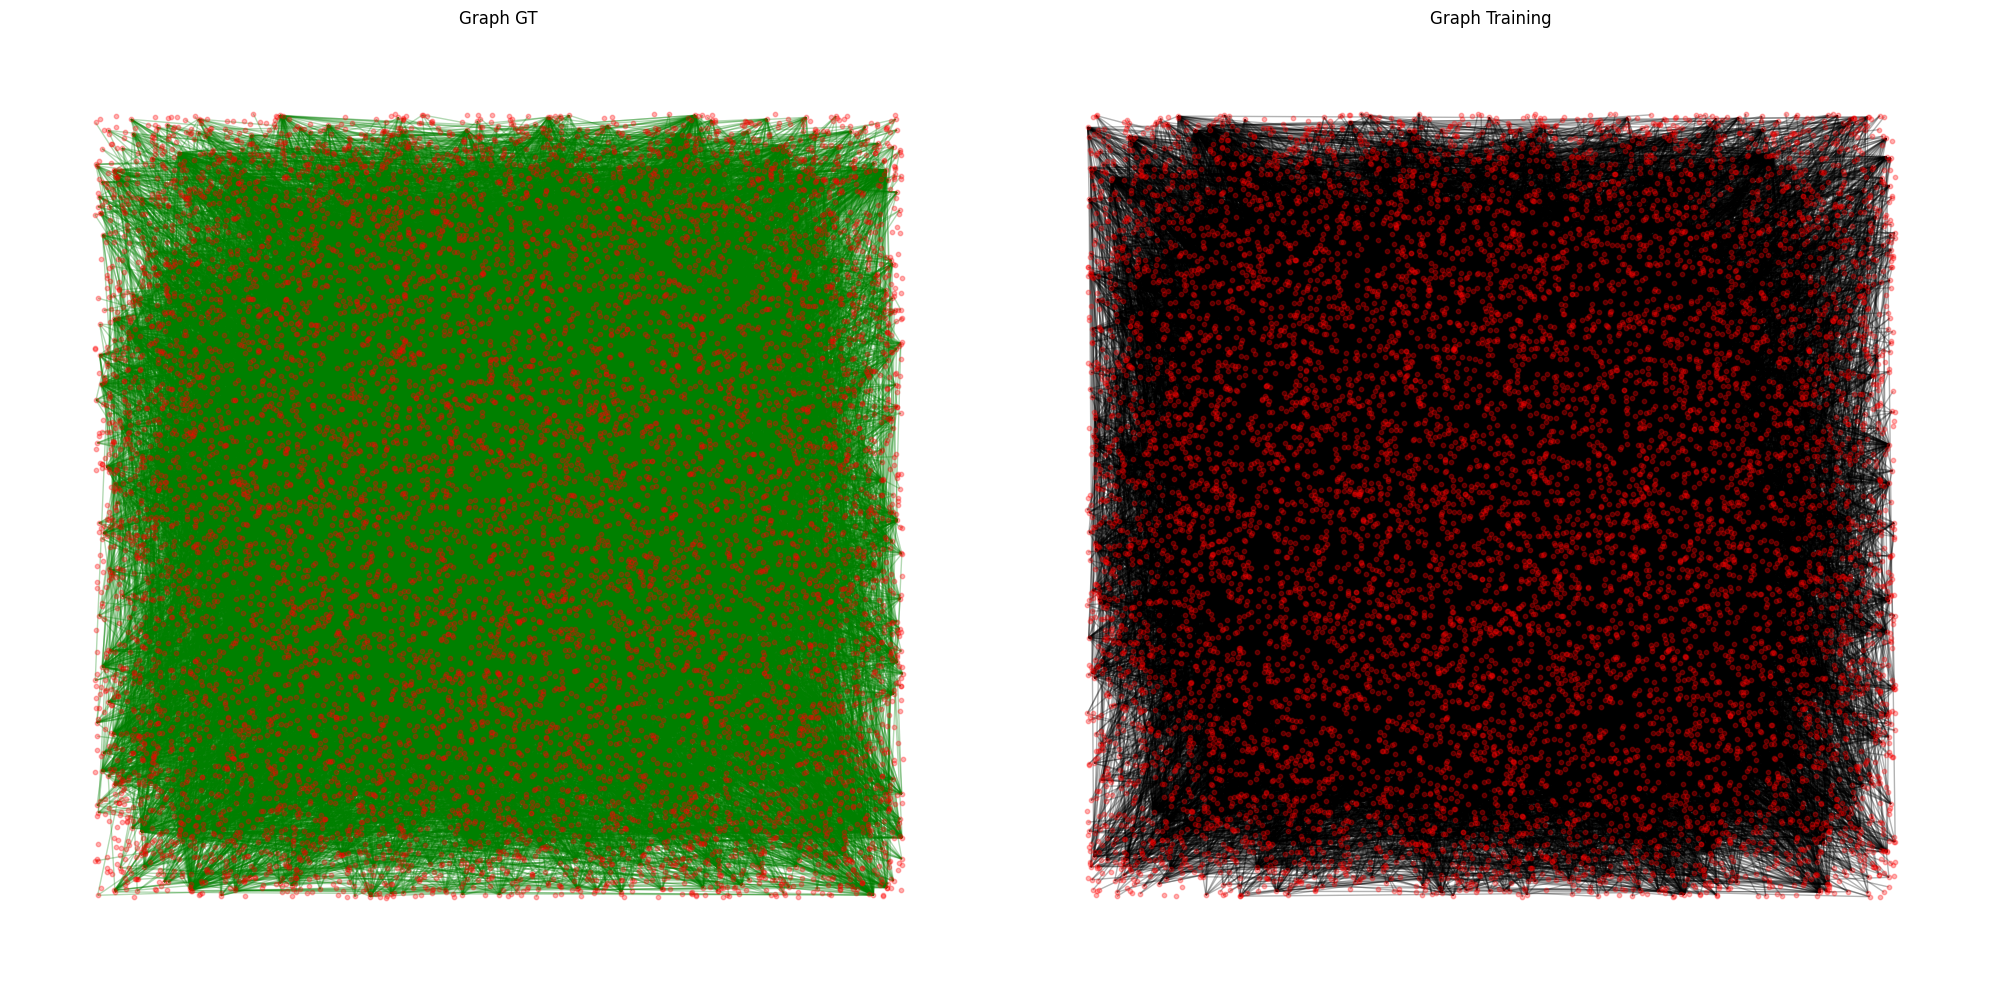

In [9]:
# in this cell, i created a graph in which the nodes are all the softwares which are bought or viewed together

True_edges = final_rel_df[final_rel_df['True_label']==1][['source', 'target']].reset_index(drop=True)
training_edges = final_rel_df[final_rel_df['training_edge']==1][['source', 'target']].reset_index(drop=True)

node_list = set(final_rel_df['source']) | set(final_rel_df['target'])
node_df = node_df[node_df['asin'].isin(node_list)]

graph_training = nx.Graph()
graph_training.add_nodes_from(node_list)
graph_training.add_edges_from(training_edges[['source', 'target']].values)

graph_GT = nx.Graph()
graph_GT.add_nodes_from(node_list)
graph_GT.add_edges_from(True_edges[['source', 'target']].values)


print(f"Number of nodes in GT: {graph_GT.number_of_nodes()}")
print(f"Number of edges in GT: {graph_GT.number_of_edges()}")
print(f"highest degree of node in GT: {max(dict(graph_GT.degree()).values())}")

print(f"Number of nodes in training: {graph_training.number_of_nodes()}")
print(f"Number of edges in training: {graph_training.number_of_edges()}")
print(f"highest degree of node in training: {max(dict(graph_training.degree()).values())}")

plt.figure(figsize=(20, 10))
layout = (1,2)  

# Plot the first graph (graph_GT)
plt.subplot2grid(layout, (0, 0))
nx.draw(graph_GT, node_size=10, alpha=0.3, node_color='red', edge_color='green', with_labels=False, pos=nx.random_layout(graph_GT))
plt.title('Graph GT')

# Plot the second graph (graph_training)
plt.subplot2grid(layout, (0, 1))
nx.draw(graph_training, node_size=10, alpha=0.3, node_color='red', with_labels=False, pos=nx.random_layout(graph_training))
plt.title('Graph Training')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
pos_count = (final_rel_df['training_edge'] == 1).sum()
total = final_rel_df.size
print('positive results:', pos_count, 'of', total, f'(% {pos_count/total*100})')

positive results: 21306 of 226880 (% 9.390867418899859)


In [11]:

# final_dataset = final_rel_df # TODO: must be enhanced

print(f"Number of nodes: {graph_training.number_of_nodes()}")
print(f"Number of edges: {graph_training.number_of_edges()}")

# Node embedding and feature engineering
def node2vec_embedding(G, dimension = 64, walk_length = 20, num_walks = 50, number_of_workers = 4):
    node2vec = Node2Vec(G, dimensions=dimension, walk_length=walk_length, num_walks=num_walks, workers=number_of_workers)

    # Fit the model to the graph
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Get node embeddings
    node_embeddings = {node: model.wv[node] for node in G.nodes}
    
    node_embedding_df = pd.DataFrame.from_dict(node_embeddings, orient='index', columns=[f'dim_{i+1}' for i in range(dimension)])

    return node_embedding_df

node_embedding_df = node2vec_embedding(graph_training)
node_embedding_df['asin'] = node_embedding_df.index



Number of nodes: 9676
Number of edges: 21306


Computing transition probabilities:   0%|          | 0/9676 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 9676/9676 [00:04<00:00, 2068.62it/s]


In [12]:
node_df = pd.merge(node_df, node_embedding_df, how='inner', on='asin')
print(node_df)


            asin  price  number_of_ratings  avg_rating  File & Print Servers  \
0     0080964184  99.00                5.0    2.400000                     0   
1     0439319005   0.00                2.0    4.500000                     0   
2     043934302X  28.30                1.0    5.000000                     0   
3     0439381673  19.90               10.0    3.600000                     0   
4     043945669X  12.99               31.0    3.096774                     0   
...          ...    ...                ...         ...                   ...   
9671  B00L313JO4  12.99                3.0    5.000000                     0   
9672  B00L46HH0K   0.00                3.0    5.000000                     0   
9673  B00L48QI9Y   0.00                3.0    4.666667                     0   
9674  B00L48H1J0   0.00                2.0    5.000000                     0   
9675  B00LEZEY4S  45.51                3.0    5.000000                     0   

      Training  Remote Access  Linux & 

In [14]:
import numpy as np


attr_cols = node_df.columns[1:]
# distance_df = pd.DataFrame(columns=['source', 'target', 'True_label', 'training_edge'] + [f'{col[:-1]}_distance' for col in attr_cols])

distance_data_list = []

# Calculate norm distances for each attribute separately
for index, row in final_rel_df.iterrows():
    node1 = node_df[node_df['asin'] == row["source"]]
    node2 = node_df[node_df['asin'] == row["target"]]

    edge_dict = {"source": row["source"], "target": row["target"], "True_label": row["True_label"], "training_edge": row["training_edge"]}  
    attribute_distances = np.abs(node1[attr_cols].values - node2[attr_cols].values)
    
    # Update edge_dict with attribute distances as lists
    edge_dict.update({f'{attribute[:-1]}_distance': attribute_distances[:, i].tolist()[0] for i, attribute in enumerate(attr_cols)})

    distance_data_list.append(edge_dict)

distance_df = pd.DataFrame(distance_data_list)
print(distance_df)

           source      target  True_label  training_edge  pric_distance  \
0      0080964184  B002CIP12U           0              0          36.13   
1      0080964184  B00CH6ATMO           0              1          50.00   
2      0080964184  B00CH6AWOY           0              0          20.00   
3      0080964184  B00CH6AXPW           0              0          20.00   
4      0080964184  B00EOI2SR2           0              0           0.99   
...           ...         ...         ...            ...            ...   
56715  B00KZ0H3SC  B00L2G7FB8           0              0           0.00   
56716  B00KZ0RY4A  B00L2G7FB8           0              0           0.00   
56717  B00L313JO4  B00LEZEY4S           0              0          32.52   
56718  B00L46HH0K  B00L48QI9Y           0              0           0.00   
56719  B00L48QI9Y  B00L48H1J0           0              1           0.00   

       number_of_rating_distance  avg_ratin_distance  \
0                          148.0           

In [15]:
# creating the dataset of training in which each data is defined based 
# on the edges in the final_rel_df as contain the distance between
#  the feature vector of nodes incident to that edge and the value of its existance as bought together

X_df = distance_df

X_df['edge'] = X_df.apply(lambda row: set([row['source'], row['target']]), axis=1)

Y_df = X_df[["edge", "True_label"]]
X_df = X_df.drop(['True_label','source','target'], axis=1)

other_columns = [col for col in X_df.columns if col != "edge"]
new_column_order = ["edge"] + other_columns
X_df = X_df[new_column_order]

X_df.set_index("edge", inplace=True)
Y_df.set_index("edge", inplace=True)

print(X_df)
print(Y_df)

                          training_edge  pric_distance  \
edge                                                     
{0080964184, B002CIP12U}              0          36.13   
{0080964184, B00CH6ATMO}              1          50.00   
{B00CH6AWOY, 0080964184}              0          20.00   
{0080964184, B00CH6AXPW}              0          20.00   
{0080964184, B00EOI2SR2}              0           0.99   
...                                 ...            ...   
{B00L2G7FB8, B00KZ0H3SC}              0           0.00   
{B00L2G7FB8, B00KZ0RY4A}              0           0.00   
{B00LEZEY4S, B00L313JO4}              0          32.52   
{B00L48QI9Y, B00L46HH0K}              0           0.00   
{B00L48QI9Y, B00L48H1J0}              1           0.00   

                          number_of_rating_distance  avg_ratin_distance  \
edge                                                                      
{0080964184, B002CIP12U}                      148.0            2.149020   
{0080964184, B00CH6A

In [16]:
# code for plotting the diagrams of training

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

X = X_df.values  # Features
Y = Y_df.values.flatten()  # Target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import joblib

model = SVC()  # Support Vector Classification

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, Y_train)

# Display the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Model Training with Best Hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, Y_train)

# Model Evaluation on Test Set
Y_pred_test = best_model.predict(X_test_scaled)

# Evaluate the model on the test set
accuracy_test = accuracy_score(Y_test, Y_pred_test)
report_test = classification_report(Y_test, Y_pred_test)

# Display results
print(f"Test Set Accuracy: {accuracy_test:.2f}")
print("Test Set Classification Report:\n", report_test)

# Save the Model
joblib.dump(best_model, 'svm_model.pkl')

# Plot Learning Curve
title = "Learning Curves (SVC)"
plot_learning_curve(best_model, title, X_train_scaled, Y_train, ylim=(0.7, 1.01), cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=4)

plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
from sklearn.model_selection import GridSearchCV

# Model Selection
model = RandomForestClassifier()  # Replace with the appropriate model

# Define a parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 7. Grid Search with Cross-Validation
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, Y_train)

# Plot the learning curve during cross-validation
title = "Learning Curves (Random Forest)"
plot_learning_curve(model, title, X_train_scaled, Y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


# Display the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# 8. Model Training with Best Hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, Y_train)

# 9. Model Evaluation on Test Set
Y_pred_test = best_model.predict(X_test_scaled)

# Evaluate the model on the test set
accuracy_test = accuracy_score(Y_test, Y_pred_test)
report_test = classification_report(Y_test, Y_pred_test)

# Display results
print(f"Test Set Accuracy: {accuracy_test:.2f}")
print("Test Set Classification Report:\n", report_test)

plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

In [ ]:
random_state = 123
test_size = 0.3


X = final_dataset[['source', 'target']]
Y = final_dataset['rel']
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=test_size, random_state=10)

X_train.reset_index(drop=True)
X_test.reset_index(drop=True)
Y_train.reset_index(drop=True)
Y_test.reset_index(drop=True)


0        1
1        0
2        0
3        0
4        1
        ..
42566    1
42567    0
42568    0
42569    1
42570    0
Name: rel, Length: 42571, dtype: object

In [ ]:
estimator = SVC(kernel='rbf')
svm_model = GridSearchCV(cv = 10, estimator=estimator, param_grid={'C':[0.01, 0.1, 1]})

svm_model.fit(X_train, Y_train)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'B0084BPZO8'

--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'B000V2KKBG'
